# Baseline Models

The purpose of this exercise is to define a basseline model for Deep Learning models in this project

In [43]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [64]:
matplotlib.rcParams.update({'font.size': 18})

### Loading the dataset

In [9]:
dataset = pd.read_csv("../data_processed/webhose_google_news_2019_06_28.csv").reset_index(drop=True)

In [10]:
dataset = dataset[dataset["label"] >= 0]

In [11]:
dataset.shape

(7079, 11)

Spliting into train and test sets, using 25% of the dataset as testing

In [12]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.25, random_state=1000)

In [16]:
content_train = dataset_train["content"].values
content_test = dataset_test["content"].values
label_train = dataset_train["label"].values
label_test = dataset_test["label"].values

In [14]:
# class_count = pd.concat([
#     pd.DataFrame({"label": y_test, "test": 0}).groupby("label").count(),
#     pd.DataFrame({"label": y_train, "train": 0}).groupby("label").count()   
# ], axis=1)

In [15]:
# class_count.plot(kind="bar", subplots=True, figsize=(16,8), autopct="%.2f");

The class balance seems to be similar for train and test datasets.

### Transforming text

Using counting vectorizer

In [17]:
vectorizer = TfidfVectorizer()

In [18]:
vectorizer.fit(content_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [26]:
X_train = vectorizer.transform(content_train)
y_train = label_train

In [27]:
X_test  = vectorizer.transform(content_test)
y_test = label_test

### Training models

In [28]:
def train_classifiers(models, X_train, y_train):
    results = {}
    for name, model in models.items():
        classifier = model()
        classifier.fit(X_train, y_train)
        results[name] = classifier
        
    return results

In [29]:
def print_report(name, report):
    print("====================================================")
    print(name)
    print("====================================================")
    print(report)    

In [30]:
def print_results(results, X_test, y_test):
    for name, classifier in results.items():
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred)
        print_report(name, report)

In [31]:
models = {
    "Logistic Regression": LogisticRegression,
    "Decision Tree": DecisionTreeClassifier
}

In [32]:
results = train_classifiers(models, X_train, y_train)

/Users/cristianoaguiar/.pyenv/versions/3.7.2/envs/sm-project/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
print_results(results, X_test, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       945
           1       0.85      0.82      0.83       825

    accuracy                           0.85      1770
   macro avg       0.85      0.85      0.85      1770
weighted avg       0.85      0.85      0.85      1770

Decision Tree
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       945
           1       0.80      0.80      0.80       825

    accuracy                           0.81      1770
   macro avg       0.81      0.81      0.81      1770
weighted avg       0.81      0.81      0.81      1770



In [67]:
data_grouped = []
for name, group in dataset_test.groupby("domain"):
    X_test_group = vectorizer.transform(group["content"])
    y_pred_group = results["Decision Tree"].predict(X_test_group)
    conservative_count = y_pred_group.sum()
    total = y_pred_group.shape[0]
    liberal_count =  total - conservative_count
    side = "conservative" if group["label"].max() == 1 else "liberal"
    data_grouped.append({
        "domain": name,
        "liberal": liberal_count,
        "conservative": conservative_count,
        "side": side,
        "total": total
    })
data_grouped = pd.DataFrame(data_grouped).sort_values("total", ascending=False).head(4)

In [68]:
data_grouped["conservative"] = data_grouped["conservative"] / data_grouped["total"] * 100
data_grouped["liberal"] = data_grouped["liberal"] / data_grouped["total"] * 100

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, 'Sources'),
 Text(0.5, 1.0, 'Decision Tree')]

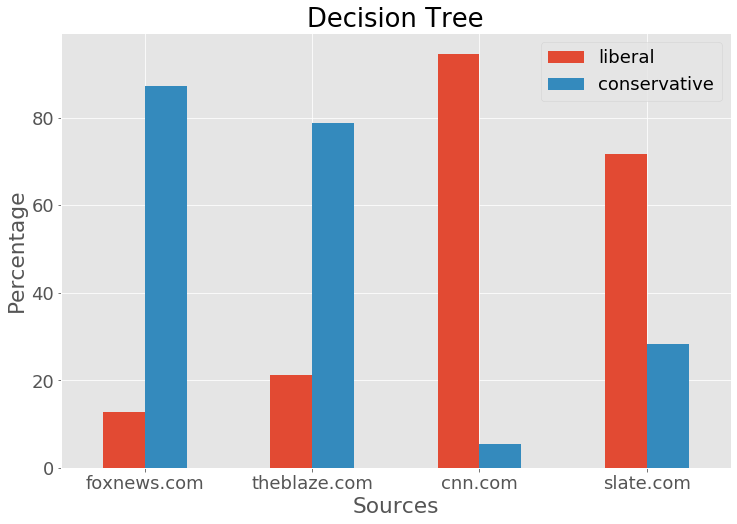

In [70]:
data_grouped = data_grouped.sort_values("side")
ax = data_grouped[["liberal", "conservative", "domain"]].plot(kind="bar", x="domain", rot=0, figsize=(12,8));
ax.set(xlabel="Sources", ylabel="Percentage", title="Decision Tree")

In [61]:
data_grouped

,conservative,domain,liberal,side,total
0,6.759907,cnn.com,93.240093,liberal,429
3,81.200000,foxnews.com,18.800000,conservative,250
14,86.702128,theblaze.com,13.297872,conservative,188
11,19.411765,slate.com,80.588235,liberal,170


### Predictions

In [73]:
out_of_sample_dataset = pd.read_csv("../data_processed/ALL_NEWS_bias_label.csv")

In [74]:
out_of_sample_dataset.head()

,content,label
0,republican presidential candidate ben carson s...,1
1,a nasty battle has broken out in the republica...,1
2,donald trump launched new attacks against bill...,1
3,the plunge in oil prices has given a needed br...,1
4,president obama said on friday he will meet wi...,1


In [76]:
content_oos = out_of_sample_dataset["content"].values
y_oos = out_of_sample_dataset["label"].values
X_oos = vectorizer.transform(content_oos)

In [77]:
print_results(results, X_oos, y_oos)

Logistic Regression
              precision    recall  f1-score   support

           0       0.60      0.71      0.65      6590
           1       0.63      0.52      0.57      6409

    accuracy                           0.61     12999
   macro avg       0.62      0.61      0.61     12999
weighted avg       0.62      0.61      0.61     12999

Decision Tree
              precision    recall  f1-score   support

           0       0.54      0.43      0.48      6590
           1       0.51      0.62      0.56      6409

    accuracy                           0.52     12999
   macro avg       0.53      0.53      0.52     12999
weighted avg       0.53      0.52      0.52     12999

